# Modeling reproduction rate based on government measures in effect

In [252]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

# see all columns at once with scrolling
pd.set_option('display.max_columns', None, 'display.max_rows', 100)

## Data
Create a table with

| Country | Date      | IndoorOver100 | MassGatherAll | StayHomeOrderPartial | ... | reproduction_rate |
|---------|-----------|---------------|---------------|----------------------|-----|-------------------|
| Austria | 3-10-2020 | 1             | 0             | 0                    |     | 1.5               |
| UK      | 1-2-2020  | 0             | 0             | 1                    |     | 0.8               |
| UK      | 2-4-2020  | 1             | 1             | 1                    |     | 0.2               |

In [253]:
owid = pd.read_csv('./data/1_owid/owid-covid-data.csv')
eu_response = pd.read_csv('./data/2_ecdc/country_response_measures.csv')

# df is the final dataset to use
df = owid[["location","date","reproduction_rate"]]
print(df.head())
print(eu_response.head())


      location        date  reproduction_rate
0  Afghanistan  2020-02-24                NaN
1  Afghanistan  2020-02-25                NaN
2  Afghanistan  2020-02-26                NaN
3  Afghanistan  2020-02-27                NaN
4  Afghanistan  2020-02-28                NaN
   Country       Response_measure  date_start    date_end
0  Austria  AdaptationOfWorkplace  2020-03-10         NaN
1  Austria         BanOnAllEvents  2020-11-03         NaN
2  Austria            ClosDaycare  2020-03-16  2020-05-04
3  Austria     ClosDaycarePartial  2020-11-17  2020-12-07
4  Austria               ClosHigh  2020-03-16  2020-09-30


In [254]:
# only keep rows in df that match to a country in eu_response
df = df[[x in eu_response["Country"].unique() for x in df["location"]]]

# initialize a column for each response type with all 0s
for response in eu_response["Response_measure"].unique():
    try:
        df.insert(len(df.columns), response, 0)
    except ValueError:  # ValueError thrown if df already has that column
        pass

# iterate through each government response and fill in 1s for between date_start and date_end for the correct country
for _, row in eu_response.iterrows():
    df.loc[(df["location"] == row["Country"])
        & (pd.to_datetime(df["date"]) >= pd.to_datetime(row["date_start"]))
        & (pd.to_datetime(df["date"]) < (pd.datetime(2030,1,1) if pd.isnull(pd.to_datetime(row["date_end"])) else pd.to_datetime(row["date_end"]))),    # force True if end_date == NaT
        row["Response_measure"]] = 1 # column to change
df.head(5)

,location,date,reproduction_rate,AdaptationOfWorkplace,BanOnAllEvents,ClosDaycare,ClosDaycarePartial,ClosHigh,ClosPrim,ClosPrimPartial,ClosPubAny,ClosPubAnyPartial,ClosSec,ClosSecPartial,EntertainmentVenues,GymsSportsCentres,HotelsOtherAccommodation,IndoorOver100,IndoorOver1000,MasksMandatoryAllSpaces,MasksMandatoryClosedSpaces,MasksMandatoryClosedSpacesPartial,MasksVoluntaryClosedSpacesPartial,MassGather50,MassGatherAll,NonEssentialShops,NonEssentialShopsPartial,OutdoorOver1000,OutdoorOver50,OutdoorOver500,PlaceOfWorship,PlaceOfWorshipPartial,PrivateGatheringRestrictions,RestaurantsCafes,SocialCircle,StayHomeGen,StayHomeOrder,StayHomeOrderPartial,Teleworking,EntertainmentVenuesPartial,GymsSportsCentresPartial,IndoorOver500,MasksVoluntaryAllSpaces,MasksVoluntaryAllSpacesPartial,RestaurantsCafesPartial,StayHomeGenPartial,TeleworkingPartial,BanOnAllEventsPartial,ClosHighPartial,MassGather50Partial,MassGatherAllPartial,PrivateGatheringRestrictionsPartial,AdaptationOfWorkplacePartial,ClosureOfPublicTransport,StayHomeRiskG,HotelsOtherAccommodationPartial,IndoorOver50,OutdoorOver100,WorkplaceClosures,WorkplaceClosuresPartial,MasksMandatoryAllSpacesPartial,MasksVoluntaryClosedSpaces,StayHomeRiskGPartial,RegionalStayHomeOrderPartial,SocialCirclePartial,RegionalStayHomeOrder,ClosureOfPublicTransportPartial
2824,Austria,2020-02-25,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2825,Austria,2020-02-26,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2826,Austria,2020-02-27,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2827,Austria,2020-02-28,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2828,Austria,2020-02-29,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Linear Model
We perform OLS with each of the categories of responses as inputs (1 if active, 0 if not) to predict reproductive rate on that day (may have to shift reproductive rate by $\tau$ days)

The categories with largest negative coefficients are the most impactful (they reduce the reproductive rate the most)

In [264]:
from sklearn.linear_model import LinearRegression

In [268]:
# prepare data
df = df.dropna()
X = df[eu_response["Response_measure"].unique()]
Y = df["reproduction_rate"] # TODO normalize to gaussian [0,1]

In [266]:
linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
Y_pred = linear_regressor.predict(X)

In [276]:
linear_regressor.score(X, Y)

0.22886427406935528

Text(0.5, 1.0, 'Coefficients $\\beta$ for each response_measure')

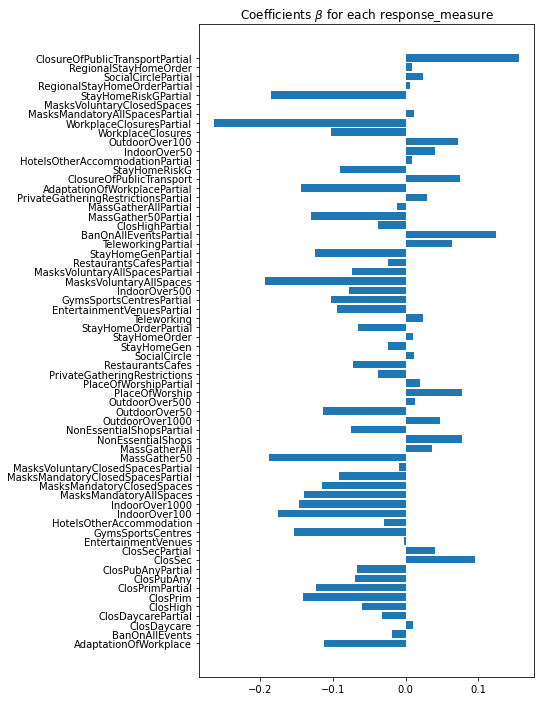

In [295]:
coefficients = dict(zip(eu_response["Response_measure"].unique(), linear_regressor.coef_))
plt.figure(figsize=(6,12))
plt.barh(y = list(coefficients.keys()), width = coefficients.values())
plt.title("Coefficients $\\beta$ for each response_measure")